In [18]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
# from sklearn.metrics import confusion_matrix, accuracy_score,recall_score, precision_score
from sklearn.model_selection import train_test_split


# Common imports
import numpy as np
import os, time
import pandas as pd
import pandas_ta as ta

from statsmodels.graphics.tsaplots import plot_acf

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, GRU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError

from tabulate import tabulate

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', dpi=100)
import seaborn as sns; sns.set()

In [20]:
df = pd.read_csv("BTC-USD.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [ ]:
df.shape

(3340, 7)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3340 non-null   object 
 1   Open       3340 non-null   float64
 2   High       3340 non-null   float64
 3   Low        3340 non-null   float64
 4   Close      3340 non-null   float64
 5   Adj Close  3340 non-null   float64
 6   Volume     3340 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 182.8+ KB


In [ ]:
df.isnull().values.any()

False

In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3340.000000,3340.000000,3340.000000,3340.000000,3340.000000,3.340000e+03
mean,14165.940058,14500.513576,13803.375293,14175.011570,14175.011570,1.646430e+10
std,15983.541930,16373.265483,15542.872293,15982.865863,15982.865863,1.920332e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,882.473267,902.352005,833.310746,891.169754,891.169754,1.433627e+08
50%,8112.123779,8270.116699,7900.635498,8124.468994,8124.468994,1.082725e+10
75%,22868.567871,23314.871582,22444.786621,22931.519531,22931.519531,2.697648e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [21]:
df['Date'] = pd.to_datetime(df['Date'])
#train_df.set_index('Date', inplace=True)

In [ ]:
print("Duplicate rows:", df.duplicated().sum())

Duplicate rows: 0


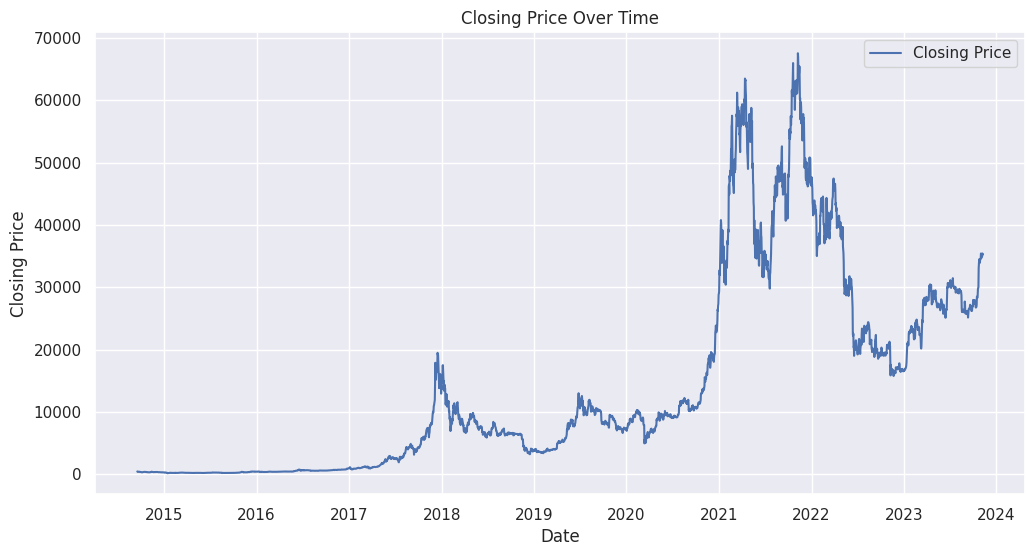

In [22]:
# Plotting example (adjust as needed)
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Closing Price')
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [23]:
# Calculate residuals
df['Residuals_Percentage_Change'] = df['Close'].pct_change() * 100

# Adding technical indicators
df['RSI']=ta.rsi(df.Close, length=15)
df['EMAF']=ta.ema(df.Close, length=20)
df['EMAM']=ta.ema(df.Close, length=100)
df['EMAS']=ta.ema(df.Close, length=150)
df = df.dropna()

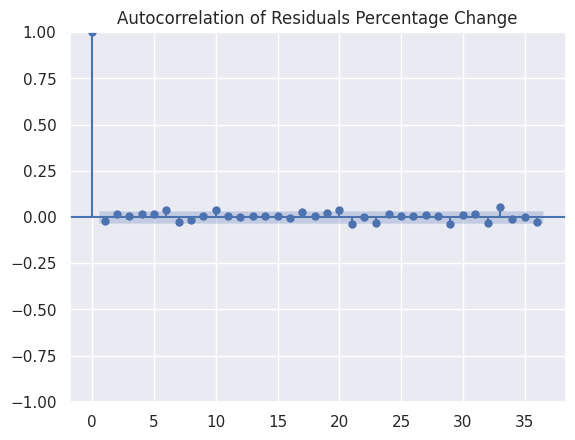

In [8]:
# Autocorrelation Analysis
plot_acf(df['Residuals_Percentage_Change'])
plt.title('Autocorrelation of Residuals Percentage Change')
plt.show()

<ipython-input-9-fc63b8ba24bf>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True,linewidths=0.5)


<Axes: >

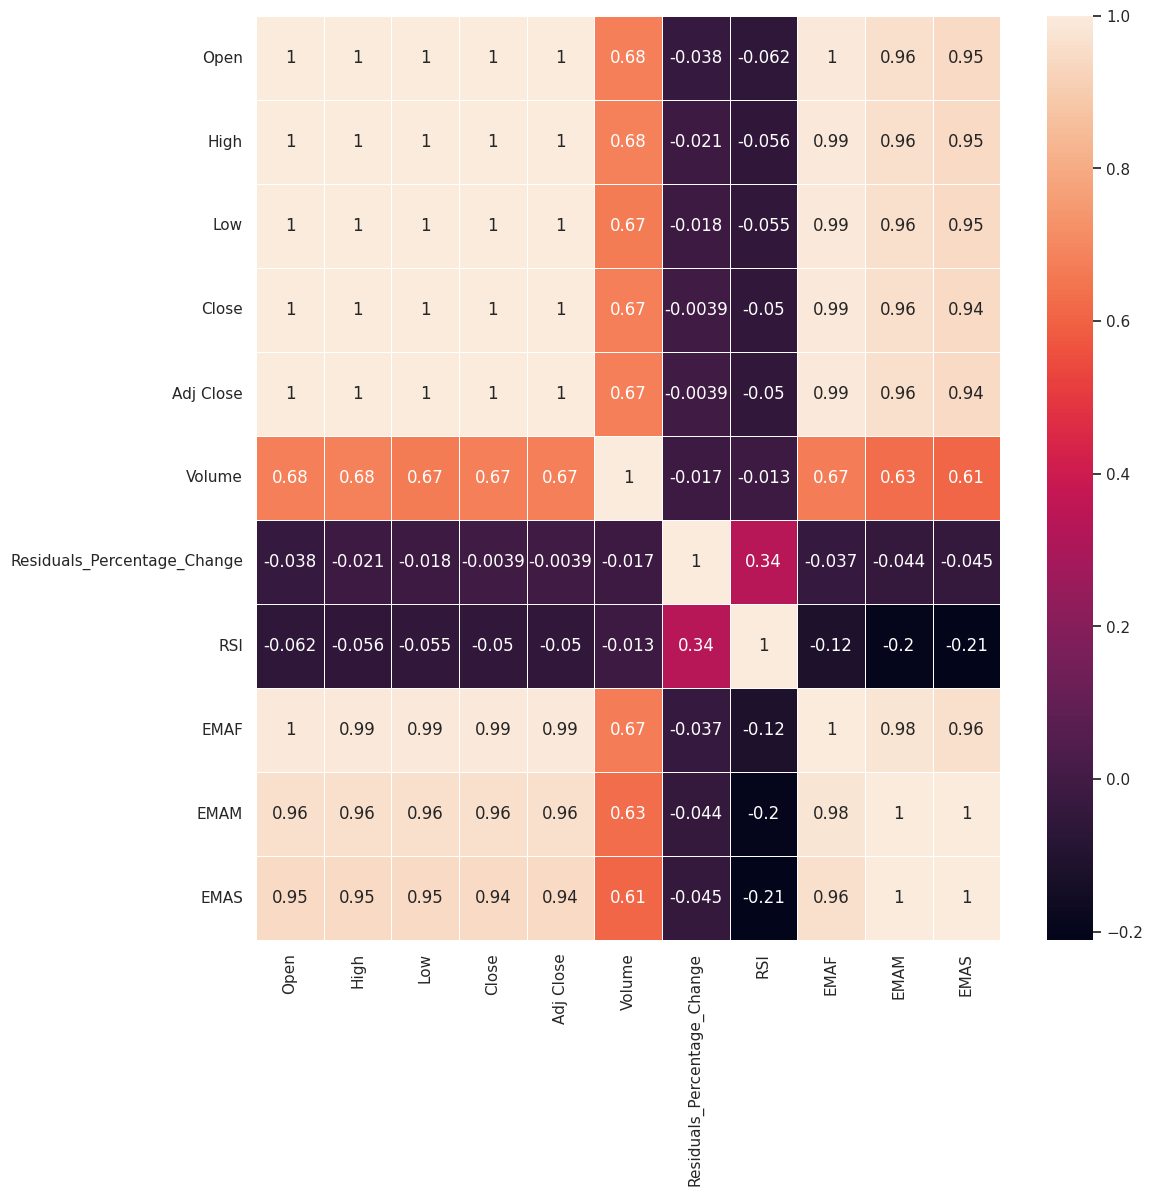

In [9]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(),annot=True,linewidths=0.5)

In [37]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from tabulate import tabulate

# Function to create sequences from the data
def create_sequences(data, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        target = data[i+sequence_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Function to create and compile the baseline RNN model
def simpleRNN(rnn_units,learning_rate,additional_layers=0):
    model = Sequential()
    model.add(SimpleRNN(rnn_units, activation='relu', input_shape=(X_train.shape[1], 1)))
    if additional_layers>0:
      for units in range(additional_layers):
        model.add(SimpleRNN(rnn_units, activation='relu'))
    model.add(Dense(1, activation='relu'))
    optimizer=Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_absolute_error',metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])
    return model

# Function to create and compile the LSTM model
def create_lstm_model(lstm_units, dropout_rate, learning_rate,additional_layers=0):
    model = Sequential()
    model.add(LSTM(lstm_units, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    if additional_layers>0:
      for units in range(additional_layers):
          model.add(LSTM(lstm_units, activation='relu', return_sequences=True))
          model.add(Dropout(dropout_rate))
          model.add(BatchNormalization())

    model.add(LSTM(units=lstm_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_absolute_error',metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])
    return model

def create_gru_model(gru_units, dropout_rate, learning_rate,additional_layers=0):
    model = Sequential()
    model.add(GRU(gru_units, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    if additional_layers>0:
      for units in range(additional_layers):
          model.add(GRU(gru_units, activation='relu', return_sequences=True))
          model.add(Dropout(dropout_rate))
          model.add(BatchNormalization())

    model.add(GRU(units=gru_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_absolute_error',metrics=[RootMeanSquaredError(),MeanAbsoluteError(),MeanAbsolutePercentageError()])
    return model

# Function to train the model
def train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    _model = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=2)
    table = [[f'Training {model.loss} Loss',f'Validation {model.loss} Loss','Training RMSE'	,'Training MAE',	'Training MAPE','Validation RMSE'	,'Validation MAE',	'Validation MAPE'],
         [_model.history['loss'][-1],_model.history['val_loss'][-1] ,_model.history['root_mean_squared_error'][-1], _model.history['mean_absolute_error'][-1], _model.history['mean_absolute_percentage_error'][-1],_model.history['val_root_mean_squared_error'][-1] ,_model.history['val_mean_absolute_error'][-1] ,_model.history['val_mean_absolute_percentage_error'][-1] ]]
    print("\n",tabulate(table,headers='firstrow'),"\n\n")
    return _model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae=mean_absolute_error(y_test, predictions)
    mape=mean_absolute_percentage_error(y_test, predictions)
    visual_inspection(y_test, predictions)
    plot_residuals(y_test, predictions)
    print(f"Model Mean Absolute error:{mae}")
    print(f"Model Mean Absolute Percentage error:{mape}")
    return mse

def visual_inspection(actual, predicted):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted', linestyle='dashed')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time Steps')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

def plot_residuals(y_true, y_pred):
    y_pred=y_pred.reshape(-1)
    residuals = y_true - y_pred

    fig, axs = plt.subplots(1,2,figsize=(12,5))
    plt.figure(dpi=80, facecolor='w', edgecolor='k')
    axs[0].scatter(y_pred,residuals, color='blue', marker='o',label='Fitted values')
    axs[0].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Residuals')
    axs[0].set_title('Residual plot')
    axs[1].hist(residuals, linewidth=1,bins=20, edgecolor='black')
    axs[1].set_title('Histogram plot of residual')
    axs[0].legend()
    axs[1].legend()
    plt.show()

In [25]:
# Seperating target variable
data = df['Residuals_Percentage_Change'].values

# Normalize data
scaler = MinMaxScaler()
data = scaler.fit_transform(data.reshape(-1, 1)).reshape(-1)

# Create sequences
sequence_length = 10
X, y = create_sequences(data, sequence_length)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Reshape for LSTM input
input_shape = (X_train.shape[1], 1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# Simple RNN

Epoch 1/10
40/40 - 2s - loss: 0.6000 - root_mean_squared_error: 0.6031 - mean_absolute_error: 0.6000 - mean_absolute_percentage_error: 99.9607 - val_loss: 0.5916 - val_root_mean_squared_error: 0.5940 - val_mean_absolute_error: 0.5916 - val_mean_absolute_percentage_error: 100.0000 - 2s/epoch - 43ms/step
Epoch 2/10
40/40 - 0s - loss: 0.6000 - root_mean_squared_error: 0.6031 - mean_absolute_error: 0.6000 - mean_absolute_percentage_error: 99.9607 - val_loss: 0.5916 - val_root_mean_squared_error: 0.5940 - val_mean_absolute_error: 0.5916 - val_mean_absolute_percentage_error: 100.0000 - 196ms/epoch - 5ms/step
Epoch 3/10
40/40 - 0s - loss: 0.6000 - root_mean_squared_error: 0.6031 - mean_absolute_error: 0.6000 - mean_absolute_percentage_error: 99.9607 - val_loss: 0.5916 - val_root_mean_squared_error: 0.5940 - val_mean_absolute_error: 0.5916 - val_mean_absolute_percentage_error: 100.0000 - 200ms/epoch - 5ms/step
Epoch 4/10
40/40 - 0s - loss: 0.6000 - root_mean_squared_error: 0.6031 - mean_absolu

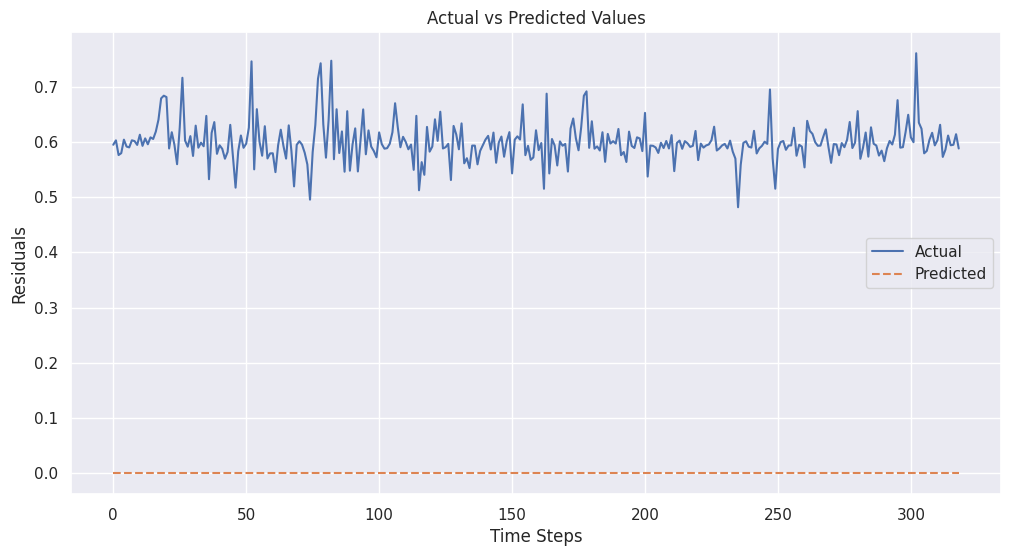

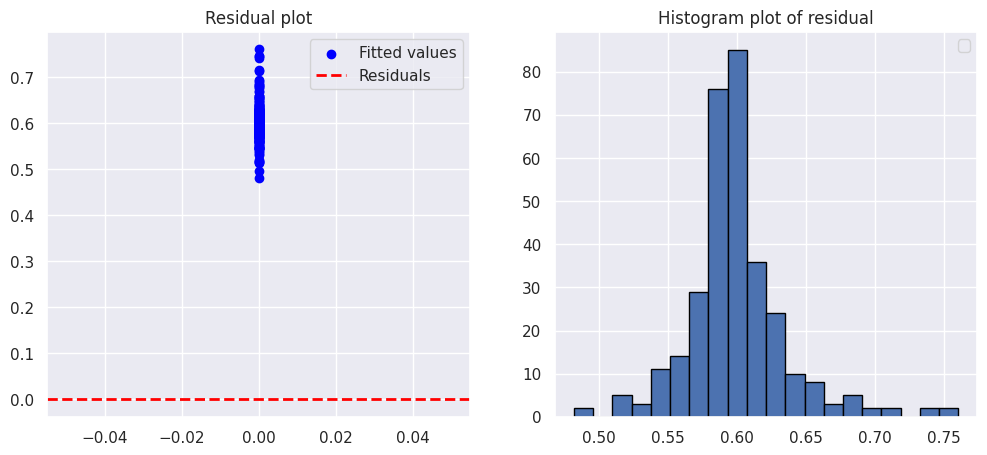

<Figure size 512x384 with 0 Axes>

Model Mean Absolute error:0.599622105708865
Model Mean Absolute Percentage error:1.0
Baseline Model RMSE: 0.6007053905012234


In [42]:
# Baseline model
baseline_model = simpleRNN(50,0.001)
history_baseline = train_model(baseline_model, X_train, y_train, X_val, y_val, epochs=10, batch_size=64)
rmse_baseline = np.sqrt(evaluate_model(baseline_model, X_test, y_test))
print(f"Baseline Model RMSE: {rmse_baseline}")
# print(history_baseline.history['loss'][-1],history_baseline.history['val_loss'][-1] ,history_baseline.history['root_mean_squared_error'][-1], history_baseline.history['mean_absolute_error'][-1], history_baseline.history['mean_absolute_percentage_error'][-1],history_baseline.history['val_root_mean_squared_error'][-1] ,history_baseline.history['val_mean_absolute_error'][-1] ,history_baseline.history['val_mean_absolute_percentage_error'][-1])

# LSTM

Epoch 1/10
40/40 - 7s - loss: 0.9009 - root_mean_squared_error: 1.1547 - mean_absolute_error: 0.9009 - mean_absolute_percentage_error: 324441.6250 - val_loss: 0.2346 - val_root_mean_squared_error: 0.2406 - val_mean_absolute_error: 0.2346 - val_mean_absolute_percentage_error: 39.1152 - 7s/epoch - 185ms/step
Epoch 2/10
40/40 - 1s - loss: 0.6615 - root_mean_squared_error: 0.8467 - mean_absolute_error: 0.6615 - mean_absolute_percentage_error: 517743.0000 - val_loss: 0.0473 - val_root_mean_squared_error: 0.0621 - val_mean_absolute_error: 0.0473 - val_mean_absolute_percentage_error: 7.9486 - 1s/epoch - 26ms/step
Epoch 3/10
40/40 - 1s - loss: 0.5286 - root_mean_squared_error: 0.6913 - mean_absolute_error: 0.5286 - mean_absolute_percentage_error: 78439.3750 - val_loss: 0.0379 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.0379 - val_mean_absolute_percentage_error: 6.7784 - 1s/epoch - 26ms/step
Epoch 4/10
40/40 - 1s - loss: 0.4315 - root_mean_squared_error: 0.5614 - mean_abs

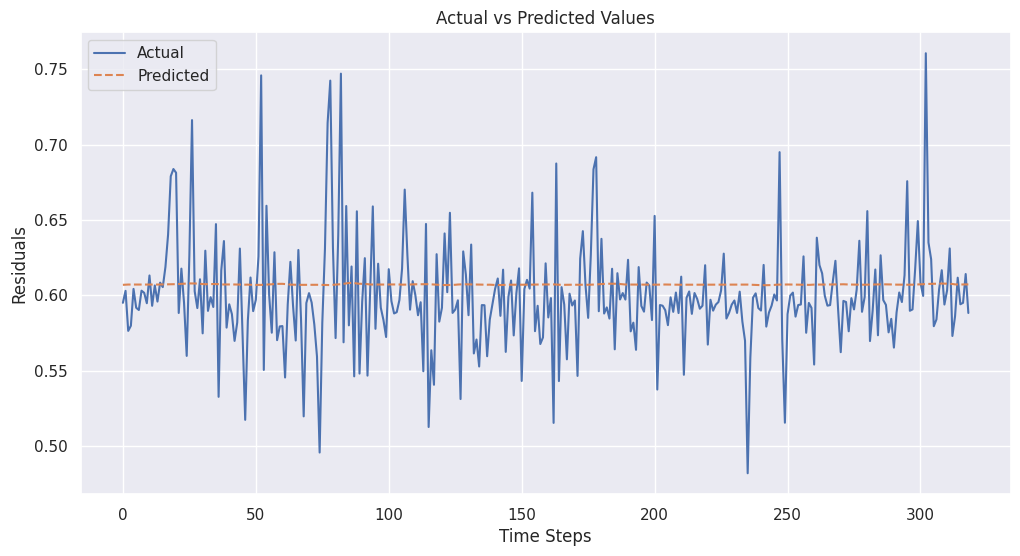

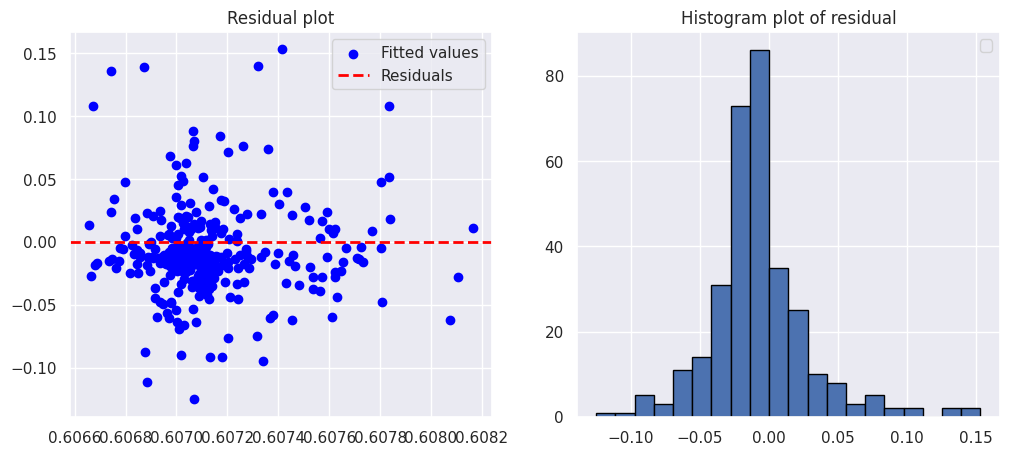

<Figure size 512x384 with 0 Axes>

Model Mean Absolute error:0.02646057868280812
Model Mean Absolute Percentage error:0.0442615824022068
Complex Model MSE: 0.001356539320547564


In [48]:
# lstm model
lstm_units = 50
dropout_rate = 0.2
learning_rate = 0.001
complex_model = create_lstm_model(lstm_units, dropout_rate, learning_rate,1)
history_complex = train_model(complex_model, X_train, y_train, X_val, y_val, epochs=10, batch_size=64)
mse_complex = evaluate_model(complex_model, X_test, y_test)
print(f"Complex Model MSE: {mse_complex}")

In [26]:
def hyperparameter_tuning(X_train, y_train, X_val, y_val,rnn_model, param_space, n_iter=10, cv=3, epochs=10, batch_size=32):
    # Define the model
    model = KerasRegressor(build_fn= rnn_model, epochs=epochs, batch_size=batch_size, verbose=0)

    # Define the search space
    search = RandomizedSearchCV(estimator=model, param_distributions=param_space, n_iter=n_iter, cv=cv,scoring='neg_mean_squared_error')

    # Perform the search
    search.fit(X_train, y_train, validation_data=(X_val, y_val))

    # Print the best parameters
    print(f'Best Parameters: {search.best_params_}')

    # Evaluate the model with the best parameters
    best_model = search.best_estimator_
    test_loss = best_model.score(X_val, y_val)
    print(f'Validation Loss with Best Parameters: {test_loss}')

    # Visual Inspection
    predictions = best_model.predict(X_val)
    visual_inspection(y_val, predictions)

<ipython-input-16-2331dbaf3992>:6: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_lstm_model, epochs=epochs, batch_size=batch_size, verbose=0)


Best Parameters: {'lstm_units': 150, 'learning_rate': 0.01, 'dropout_rate': 0.3, 'additional_layers': 5}
Validation Loss with Best Parameters: -0.0030376273207366467


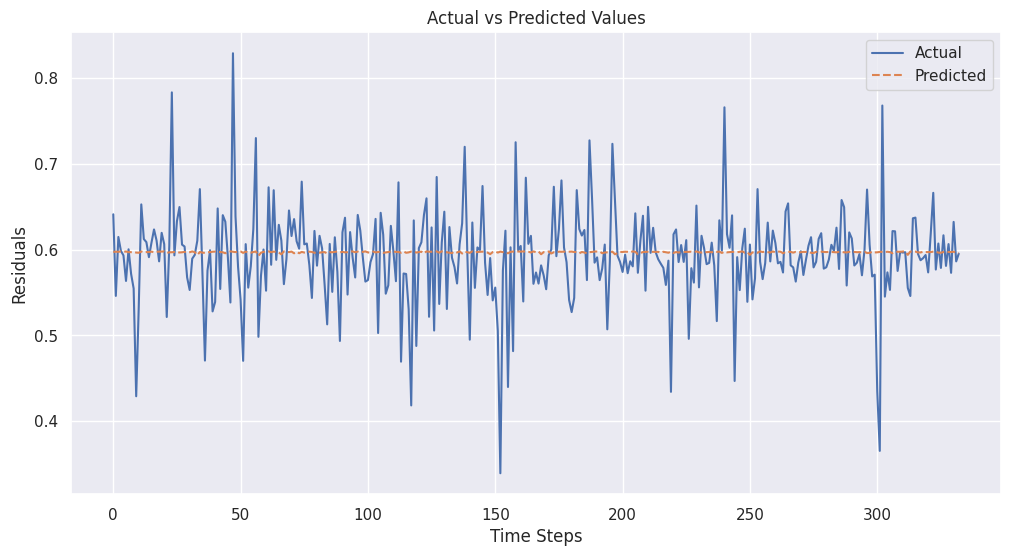

In [ ]:
# Define the hyperparameter search space
param_space = {
    'lstm_units': [50, 100, 150],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.01, 0.1],
    'additional_layers':[1,3,5,8,10]
}

# Perform hyperparameter tuning
hyperparameter_tuning(X_train, y_train, X_val, y_val, create_lstm_model,param_space, n_iter=10, cv=3, epochs=10, batch_size=32)

Epoch 1/10
40/40 - 28s - loss: 0.3994 - root_mean_squared_error: 0.8147 - mean_absolute_error: 0.3994 - mean_absolute_percentage_error: 716917.0625 - val_loss: 0.0397 - val_root_mean_squared_error: 0.0565 - val_mean_absolute_error: 0.0397 - val_mean_absolute_percentage_error: 7.1565 - 28s/epoch - 701ms/step
Epoch 2/10
40/40 - 9s - loss: 0.0595 - root_mean_squared_error: 0.0920 - mean_absolute_error: 0.0595 - mean_absolute_percentage_error: 238829.2344 - val_loss: 0.0489 - val_root_mean_squared_error: 0.0644 - val_mean_absolute_error: 0.0489 - val_mean_absolute_percentage_error: 8.8706 - 9s/epoch - 223ms/step
Epoch 3/10
40/40 - 12s - loss: 0.0531 - root_mean_squared_error: 0.0787 - mean_absolute_error: 0.0531 - mean_absolute_percentage_error: 221408.8281 - val_loss: 0.0639 - val_root_mean_squared_error: 0.0779 - val_mean_absolute_error: 0.0639 - val_mean_absolute_percentage_error: 11.5725 - 12s/epoch - 294ms/step
Epoch 4/10
40/40 - 11s - loss: 0.0529 - root_mean_squared_error: 0.0781 - 

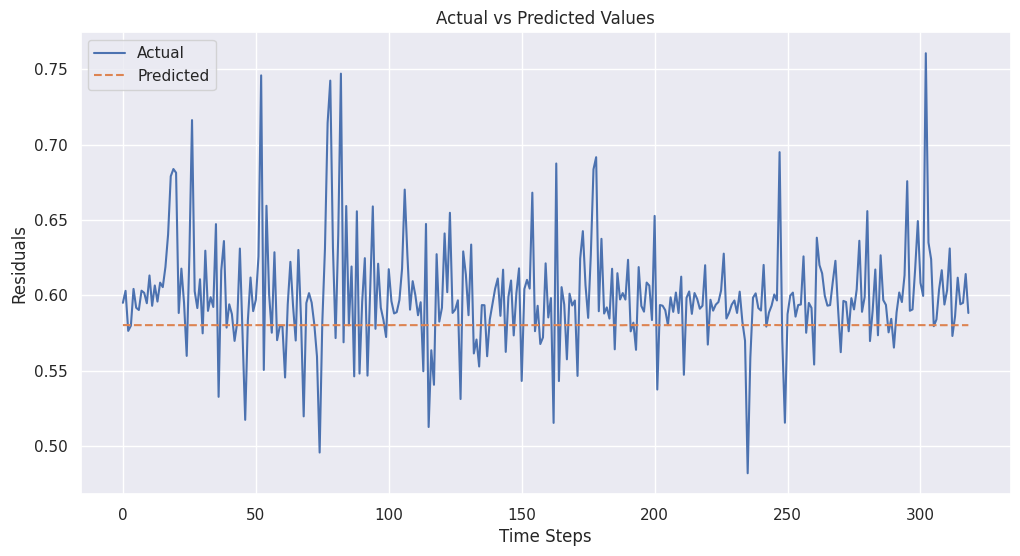

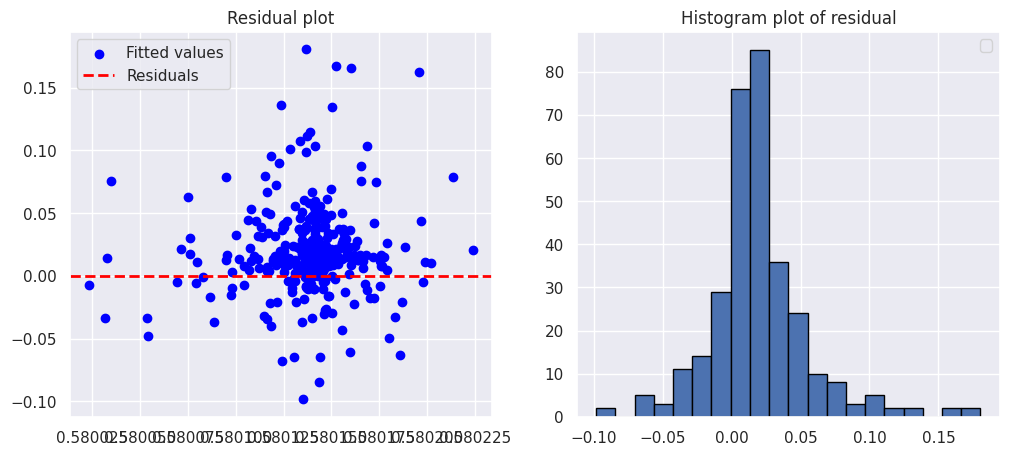

<Figure size 512x384 with 0 Axes>

Model Mean Absolute error:0.028891044066377342
Model Mean Absolute Percentage error:0.04668055697898426
Complex Model MSE: 0.001679785275890587


In [16]:
lstm_units = 150
dropout_rate = 0.3
learning_rate = 0.01
complex_model = create_lstm_model(lstm_units, dropout_rate, learning_rate,5)
history_complex = train_model(complex_model, X_train, y_train, X_val, y_val, epochs=10, batch_size=64)
mse_complex = evaluate_model(complex_model, X_test, y_test)
print(f"Complex Model MSE: {mse_complex}")

# GRU

Epoch 1/10
40/40 - 8s - loss: 0.9000 - root_mean_squared_error: 1.1507 - mean_absolute_error: 0.9000 - mean_absolute_percentage_error: 445486.6875 - val_loss: 0.2122 - val_root_mean_squared_error: 0.2186 - val_mean_absolute_error: 0.2122 - val_mean_absolute_percentage_error: 35.3247 - 8s/epoch - 188ms/step
Epoch 2/10
40/40 - 2s - loss: 0.6756 - root_mean_squared_error: 0.8652 - mean_absolute_error: 0.6756 - mean_absolute_percentage_error: 126678.4141 - val_loss: 0.0555 - val_root_mean_squared_error: 0.0704 - val_mean_absolute_error: 0.0555 - val_mean_absolute_percentage_error: 10.0735 - 2s/epoch - 51ms/step
Epoch 3/10
40/40 - 2s - loss: 0.5611 - root_mean_squared_error: 0.7164 - mean_absolute_error: 0.5611 - mean_absolute_percentage_error: 255770.8438 - val_loss: 0.0764 - val_root_mean_squared_error: 0.0893 - val_mean_absolute_error: 0.0764 - val_mean_absolute_percentage_error: 13.7653 - 2s/epoch - 46ms/step
Epoch 4/10
40/40 - 2s - loss: 0.4568 - root_mean_squared_error: 0.5885 - mean_

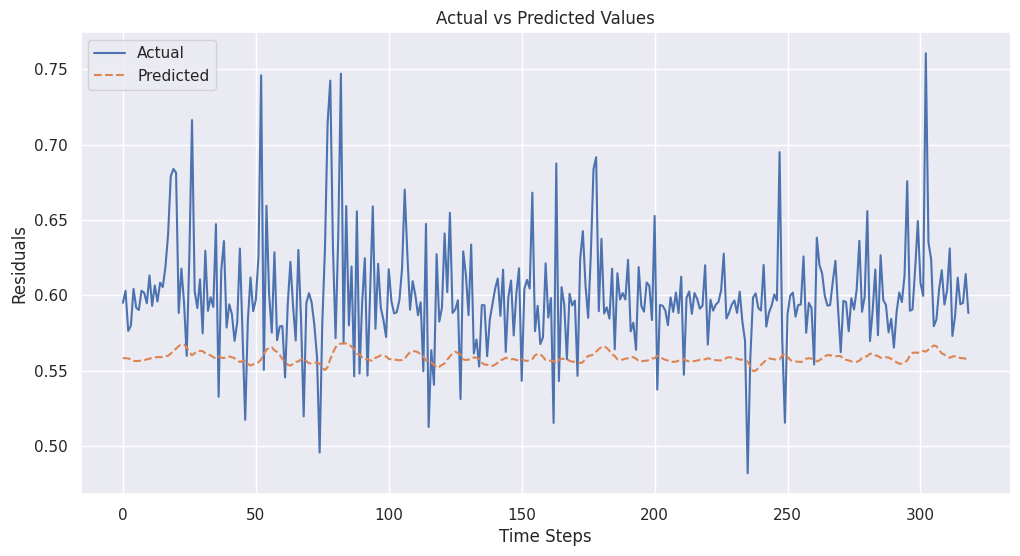

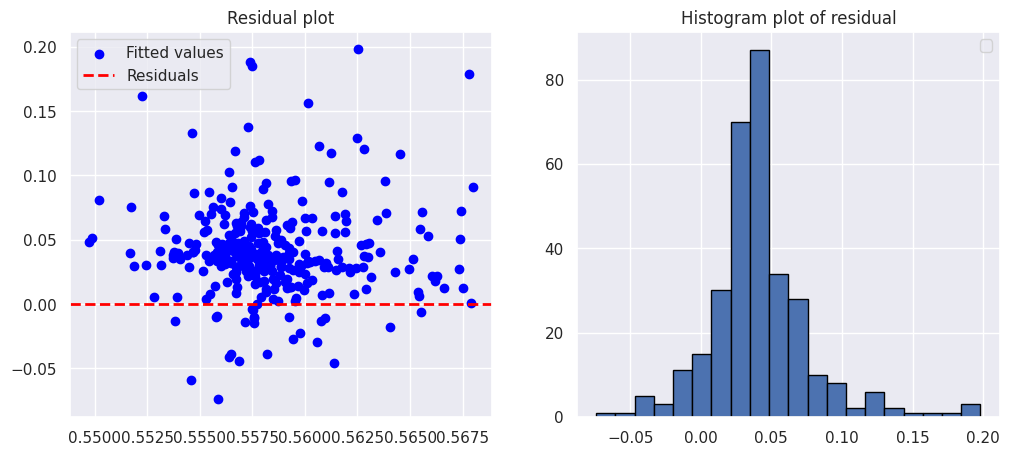

<Figure size 512x384 with 0 Axes>

Model Mean Absolute error:0.044821980428705305
Model Mean Absolute Percentage error:0.0724700755177467
GRU Model RMSE: 0.054664662556866535


In [14]:
# gru model
gru_units = 50
dropout_rate = 0.2
learning_rate = 0.001
gru_model = create_gru_model(gru_units, dropout_rate, learning_rate,1)
history_complex = train_model(gru_model, X_train, y_train, X_val, y_val, epochs=10, batch_size=64)
rmse_gru = np.sqrt(evaluate_model(gru_model, X_test, y_test))
print(f"GRU Model RMSE: {rmse_gru}")

<ipython-input-12-01bc61fc05f8>:6: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn= rnn_model, epochs=epochs, batch_size=batch_size, verbose=0)


Best Parameters: {'learning_rate': 0.01, 'gru_units': 100, 'dropout_rate': 0.4, 'additional_layers': 3}
Validation Loss with Best Parameters: -0.05288286134600639


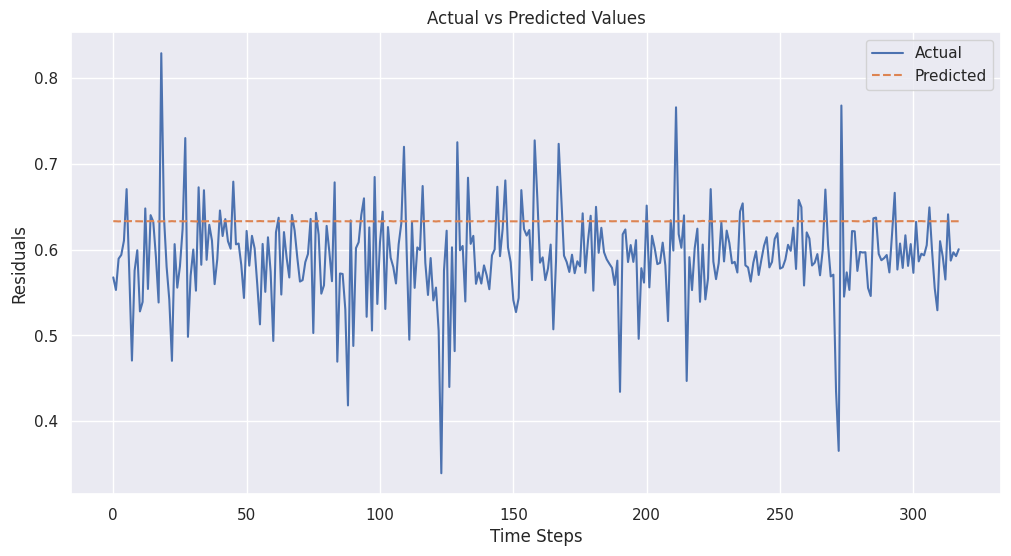

In [13]:
# Define the hyperparameter search space
param_space = {
    'gru_units': [50, 100, 150],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.01, 0.1],
    'additional_layers':[1,3,5,8,10]
}

# Perform hyperparameter tuning
hyperparameter_tuning(X_train, y_train, X_val, y_val, create_gru_model,param_space, n_iter=10, cv=3, epochs=10, batch_size=32)

Epoch 1/10
40/40 - 16s - loss: 0.5043 - root_mean_squared_error: 0.7775 - mean_absolute_error: 0.5043 - mean_absolute_percentage_error: 136877.2031 - val_loss: 0.0441 - val_root_mean_squared_error: 0.0594 - val_mean_absolute_error: 0.0441 - val_mean_absolute_percentage_error: 7.4570 - 16s/epoch - 394ms/step
Epoch 2/10
40/40 - 4s - loss: 0.0740 - root_mean_squared_error: 0.0968 - mean_absolute_error: 0.0740 - mean_absolute_percentage_error: 190395.9062 - val_loss: 0.0430 - val_root_mean_squared_error: 0.0593 - val_mean_absolute_error: 0.0430 - val_mean_absolute_percentage_error: 7.7893 - 4s/epoch - 90ms/step
Epoch 3/10
40/40 - 7s - loss: 0.0614 - root_mean_squared_error: 0.0820 - mean_absolute_error: 0.0614 - mean_absolute_percentage_error: 234275.9062 - val_loss: 0.0421 - val_root_mean_squared_error: 0.0585 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 7.6158 - 7s/epoch - 165ms/step
Epoch 4/10
40/40 - 4s - loss: 0.0591 - root_mean_squared_error: 0.0790 - mean_

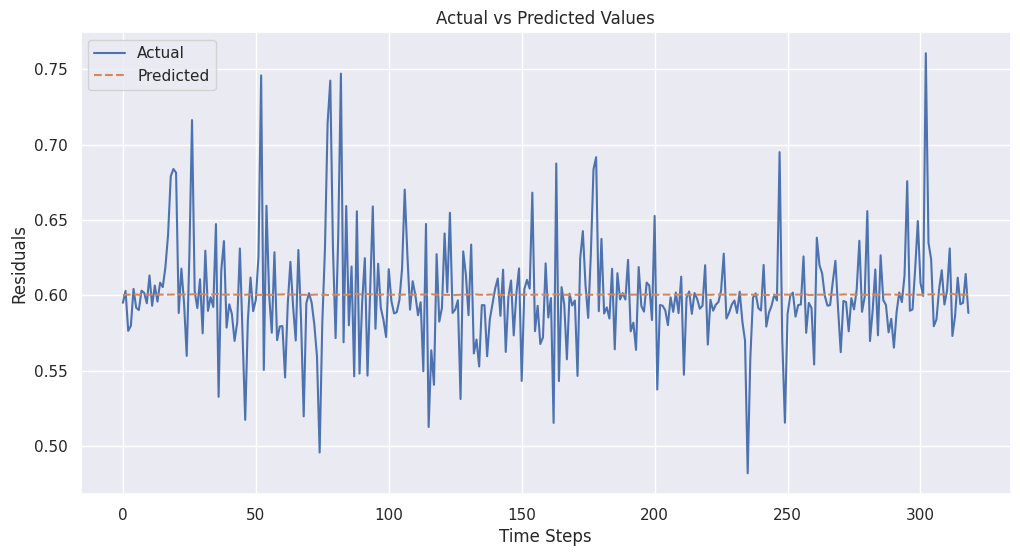

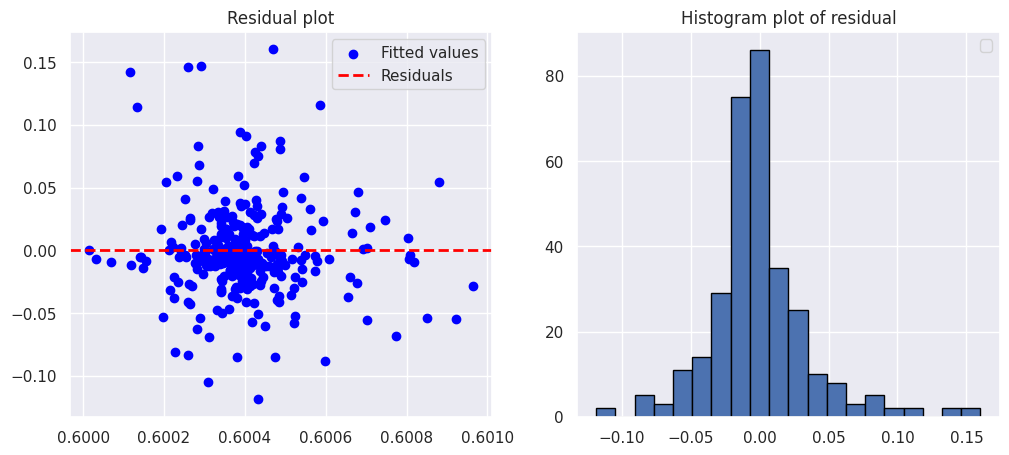

<Figure size 512x384 with 0 Axes>

Model Mean Absolute error:0.02423403031207922
Model Mean Absolute Percentage error:0.04010683973621131
GRU Model RMSE: 0.03607642765708326


In [15]:
# gru model
gru_units = 100
dropout_rate = 0.4
learning_rate = 0.01
gru_model = create_gru_model(gru_units, dropout_rate, learning_rate,3)
history_complex = train_model(gru_model, X_train, y_train, X_val, y_val, epochs=10, batch_size=64)
rmse_gru = np.sqrt(evaluate_model(gru_model, X_test, y_test))
print(f"GRU Model RMSE: {rmse_gru}")